<a href="https://colab.research.google.com/github/Alister03USA/Data-Science-Projects/blob/main/Credit_Fraud_Detection_Using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('creditcard.csv')

# Standardizes the Time and Amount Columns
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']]) # Replace original values with the scaled version - equal treatment of all features


# X is what the model will use to predict fraud and y is the target variable
X = df.drop('Class', axis=1)
y = df['Class']
# 0 - normal and 1 - fraud

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Oversample with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
# Step 6: Train Multiple Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nModel: {name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    results[name] = {"model": model, "f1": f1, "roc_auc": roc, "y_proba": y_proba}


Model: Logistic Regression
Confusion Matrix:
 [[55406  1458]
 [    8    90]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


Model: Random Forest
Confusion Matrix:
 [[56849    15]
 [   16    82]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
Confusion Matrix:
 [[56832    32]
 [   11    87]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962



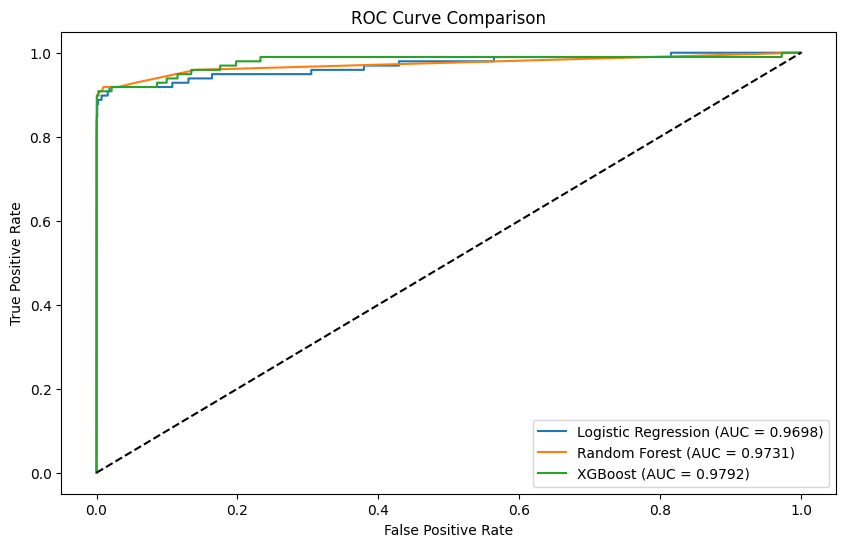

In [ ]:
# Step 7: ROC Curve Comparison: Plot two metrics (True positive and False Positive) and shows how the model balance between catching fraud cases and false alarm
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Based on the AUC, all the values for each of the ML Models are close to 1, showing that they are able predict fraud cases which turned out to be actual fraudulent

# Plot: Fraud vs Non-Fraud Distribution

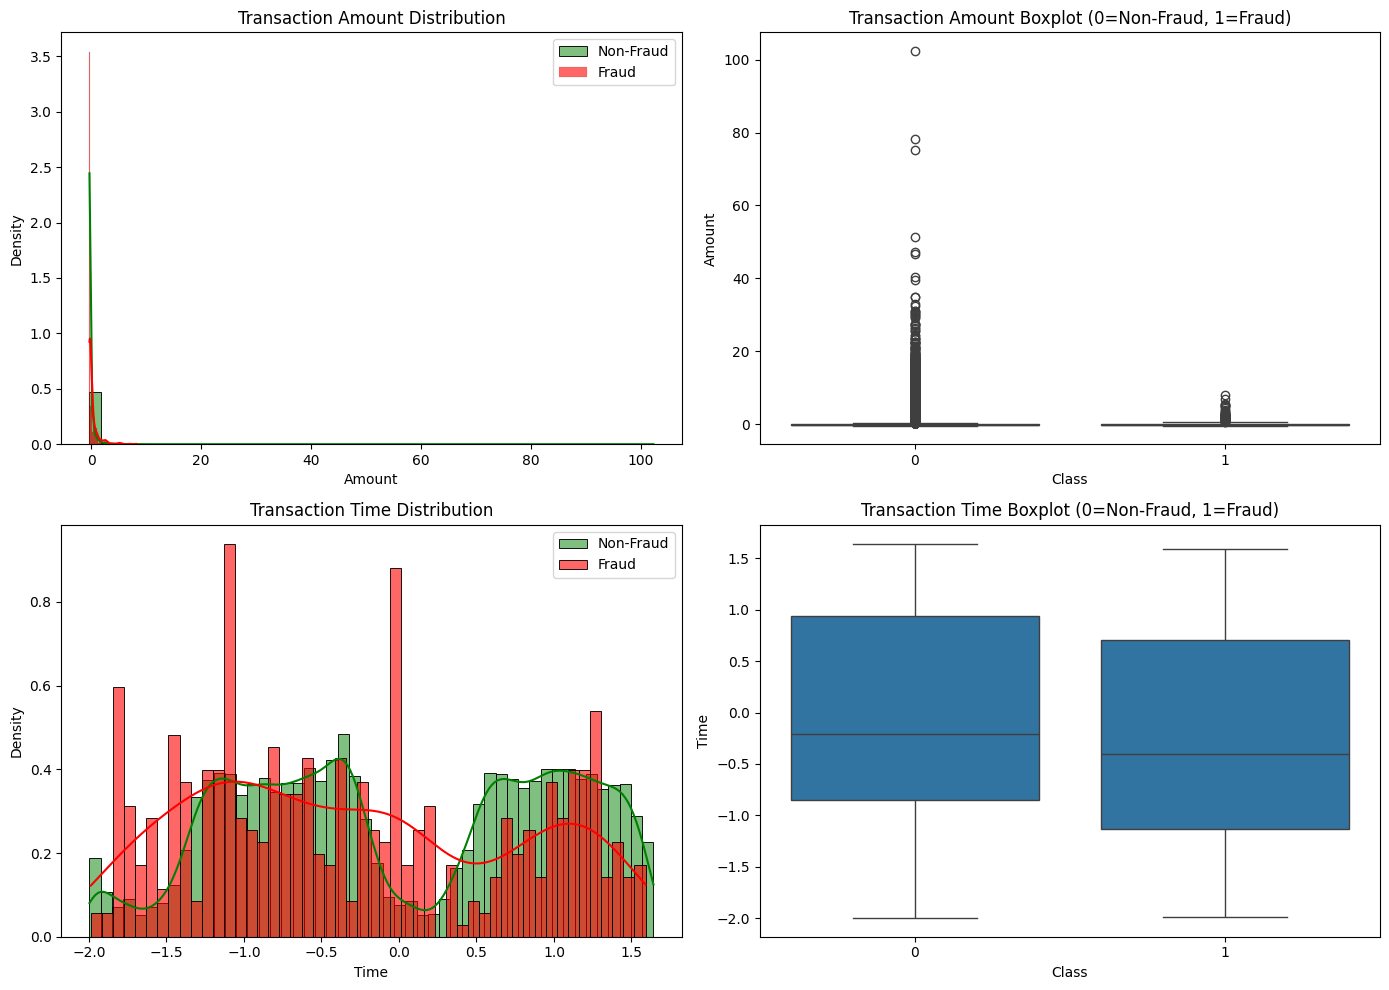

In [ ]:
# Create two subsets
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount distribution comparison - Histogram
sns.histplot(non_fraud['Amount'], bins=50, color='green', label='Non-Fraud', ax=axes[0,0], stat='density', kde=True)
sns.histplot(fraud['Amount'], bins=50, color='red', label='Fraud', ax=axes[0,0], stat='density', kde=True, alpha=0.6)
axes[0,0].set_title('Transaction Amount Distribution')
axes[0,0].legend()

# Amount distribution comparison - Boxplot
sns.boxplot(x='Class', y='Amount', data=df, ax=axes[0,1])
axes[0,1].set_title('Transaction Amount Boxplot (0=Non-Fraud, 1=Fraud)')

# Time distribution comparison - Histogram
sns.histplot(non_fraud['Time'], bins=50, color='green', label='Non-Fraud', ax=axes[1,0], stat='density', kde=True)
sns.histplot(fraud['Time'], bins=50, color='red', label='Fraud', ax=axes[1,0], stat='density', kde=True, alpha=0.6)
axes[1,0].set_title('Transaction Time Distribution')
axes[1,0].legend()

# Time distribution comparison - Boxplot
sns.boxplot(x='Class', y='Time', data=df, ax=axes[1,1])
axes[1,1].set_title('Transaction Time Boxplot (0=Non-Fraud, 1=Fraud)')

plt.tight_layout()
plt.show()

# Correlation Heatmap


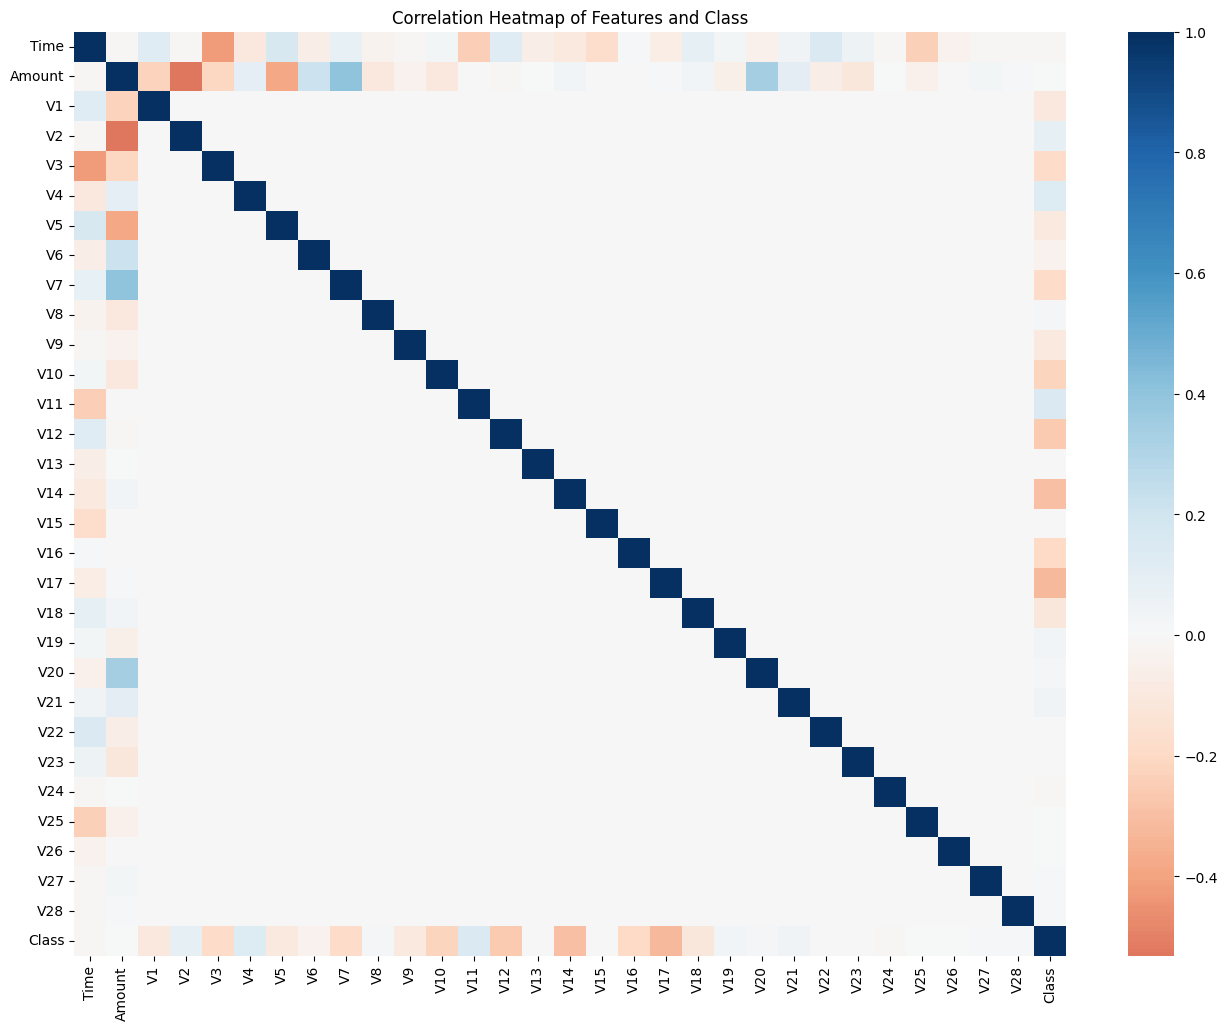

In [ ]:
# Correlation matrix (including scaled features and Class)
corr = df[['Time', 'Amount'] + [f'V{i}' for i in range(1,29)] + ['Class']].corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=False, cmap='RdBu', center=0)
plt.title('Correlation Heatmap of Features and Class')
plt.show()

Features with high absolute correlation values (strong red or blue color) are potentially strong predictors of fraud (Class = 1). These features have a linear relationship with the target.

# PCA Scatter Plot Color by Class

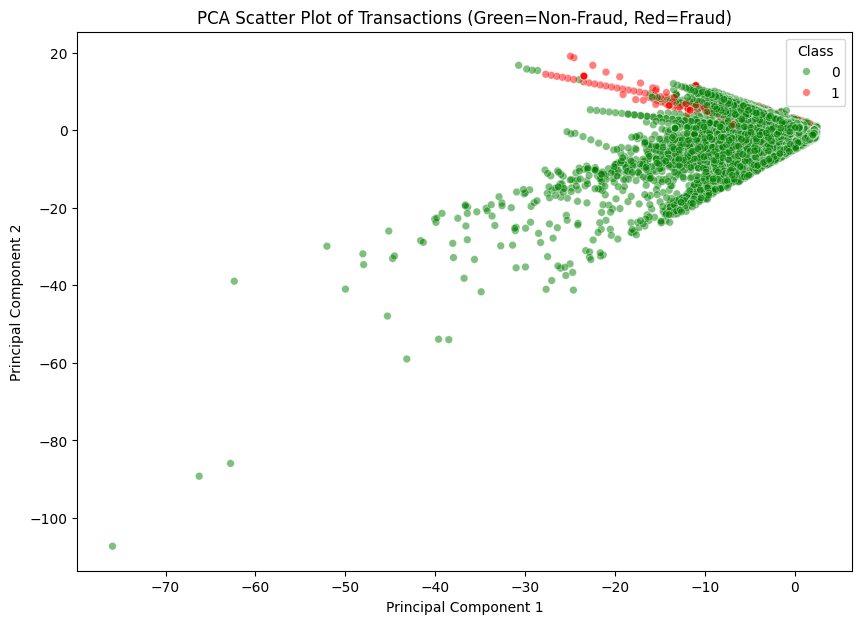

In [ ]:
from sklearn.decomposition import PCA

# Prepare features for PCA
features = ['Time', 'Amount'] + [f'V{i}' for i in range(1,29)]
X = df[features]

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot PCA scatter colored by Class
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Class'], palette=['green', 'red'], alpha=0.5, s=30)
plt.title('PCA Scatter Plot of Transactions (Green=Non-Fraud, Red=Fraud)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.show()


Points in the top-right (both PC1 and PC2 positive): These transactions have high scores on both principal axes — possibly large amounts or strong variance in PCA-dominant features.

Bottom-left (both PC1 and PC2 negative): Low scores on both principal axes — more "average" or "normal" transactions.

Red (fraud) vs Green (non-fraud): If the red points cluster in a specific region, it means PCA uncovered feature patterns that separate frauds from the majority.

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)  # X = your feature matrix
print("PC1 loadings:\n", pd.Series(pca.components_[0], index=X.columns).sort_values(ascending=False))
print("\nPC2 loadings:\n", pd.Series(pca.components_[1], index=X.columns).sort_values(ascending=False))


PC1 loadings:
 V1        0.956469
V2        0.153603
Time      0.079364
V5        0.065609
V3        0.011369
V10       0.009604
V8        0.009168
V22       0.005392
V23       0.004987
V12       0.004032
V19       0.003578
V9        0.003559
V16       0.000493
V18      -0.000143
V28      -0.000255
V26      -0.000335
V24      -0.000405
V27      -0.000708
V25      -0.001149
V17      -0.001943
V13      -0.002140
V15      -0.004083
V21      -0.004178
V14      -0.004783
V11      -0.006892
V20      -0.017801
V4       -0.021590
V6       -0.031655
V7       -0.040503
Amount   -0.216861
dtype: float64

PC2 loadings:
 V2        0.822955
V3        0.206242
V5        0.157595
V8        0.030673
V10       0.021380
V9        0.010443
V23       0.009405
V11       0.009012
V19       0.006694
V25       0.006678
V15       0.005949
V22       0.004224
V13       0.001305
V17       0.000902
V26       0.000730
V16       0.000250
V24      -0.000186
V28      -0.000372
V27      -0.001519
V12      -0.002565
V14 